## Data acquisition and analysis

### Aquisition
The source we use for the pictures: https://www.kaggle.com/datasets/kacpergregorowicz/house-plant-species?resource=download
From here, we have chosen the following type of plants: Aloe_Vera, Chienese_Money_Plant, Elephant_Ear

• After downloading each of them into a different directory, their name was 1.jpg, 2.jpg, etc.
We wanted to store all of them in the same directory, so to handle this we needed to rename them. Thats why they got the names of Aloe_Vera_n.jpg, Elephant_Eat_n.jpg, etc.

• Also, they had other extensions: jpg, jpeg, png, JPG, webp. We chosed to accept the first 4.

• After the pictures was in the right place and structure, we generated a labels.csv that store the 'image names' and 'the claster they belong to' in a row.

In [ ]:
!pip install -q pandas
!pip install -q Pillow
!pip install -q matplotlib
!pip install -q torch
!pip install -q torchvision
!pip install -q pytorch_lightning
!pip install -q torchmetrics
!pip install -q gradio

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import random
from torchvision.io import read_image

from torch import tensor
from torchmetrics.classification import MulticlassAUROC
import numpy as np
import gradio as gr

In [ ]:
random.seed(42)
#directory = 'D:\\BME\\_MSC\\2_felev\\DL\\images'
directory = 'images'
labels_file_path = 'labels.csv'
#directory = '/app/images'
#labels_file_path = '/app/labels.csv'

In [ ]:
files = os.listdir(directory)
ratios = []
classes = {"aloe_vera": 0, "chinese_money_plant": 0, "elephant_ear": 0}
# Iterate through each file
for file in files:
    if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png") or file.endswith(".JPG"):
        # Open the image
        try:
            with Image.open(os.path.join(directory, file)) as img:
                name = '_'.join(file.split('_')[:-1])
                if name == 'Aloe_Vera':
                    classes["aloe_vera"] += 1
                elif name == 'Chinese_Money_Plant':
                    classes["chinese_money_plant"] += 1
                elif name == 'Elephant_Ear':
                    classes["elephant_ear"] += 1
                # Get original dimensions
                width, height = img.size
                ratio = width / height
                ratios.append(ratio)

        except Exception as inst:
            print(file + "could not be opened")
            continue
        finally:
            img.close()

    else:
        print(f"Skipping {file}: Not the expected extension")


occurrences = {item: ratios.count(item) for item in ratios}

Skipping Chinese_Money_Plant_339.Jpg: Not the expected extension
Skipping Elephant_Ear_191.webp: Not the expected extension
Skipping Elephant_Ear_99.webp: Not the expected extension
Skipping Aloe_Vera_185.jpe: Not the expected extension
Skipping Aloe_Vera_187.webp: Not the expected extension
Skipping Aloe_Vera_42.webp: Not the expected extension
Skipping Aloe_Vera_75.webp: Not the expected extension
Skipping Chinese_Money_Plant_60.Jpg: Not the expected extension
Skipping Aloe_Vera_132.webp: Not the expected extension
Skipping link_to_dataset.txt: Not the expected extension
Skipping Elephant_Ear_222.webp: Not the expected extension
Skipping Elephant_Ear_159.webp: Not the expected extension
Skipping Elephant_Ear_330.webp: Not the expected extension
Skipping Chinese_Money_Plant_75.webp: Not the expected extension
Skipping Elephant_Ear_24.webp: Not the expected extension
Skipping Elephant_Ear_29.webp: Not the expected extension


### Analysis

1) We have calculated the ratio of the pictures, and searched for the most common ones in the dataset.
The following histogram plots it: 1.0 is the most common, that is why we decided to use it as default. Our oppinion is that if a picture is a bit misshapen that does not affect the solution. We tested the ideal for this margin of error and keep the pictures between 0.6 and 1.2 ratio. (To have enough of them for training.)

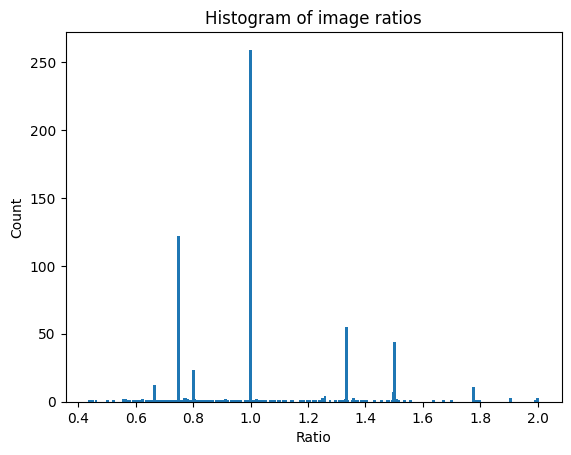

In [ ]:

# Extracting keys and values
keys = list(occurrences.keys())
values = list(occurrences.values())

# Plotting the histogram
plt.bar(keys, values, width=0.01)
plt.xlabel('Ratio')
plt.ylabel('Count')
plt.title('Histogram of image ratios')
plt.show()

# as it seen in the histogram, the most common type is 1.0, and around that -> so we choose to convert the images into 1:1 ratio

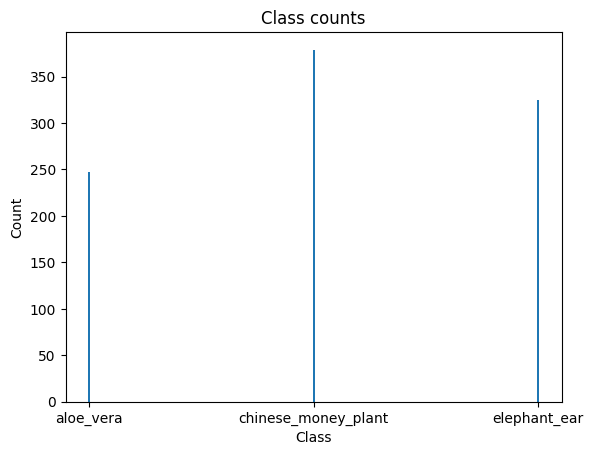

In [ ]:
# Extracting keys and values
keys = list(classes.keys())
values = list(classes.values())

# Plotting the histogram
plt.bar(keys, values, width=0.01)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class counts')
plt.show()

### Data cleaning and preparation

1) For preparation, we resized each of the pictures to the same. It has 1.0 ratio as we earlier discussed. We would like to pick a number of pixels below 100. (This ensures, that the training won't be extremely slow.)
For cleaning, we dropped the ones where the ratio was under 0.6 or above 1.2, so where it was not fit into the condition we assigned to keeping them.

In [ ]:
files = os.listdir(directory)
df = pd.DataFrame(columns=['Id', 'Label'])
for file in files:
  if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png") or file.endswith(".JPG"):
    # Open the image
    try:
      with Image.open(os.path.join(directory, file)) as img:
        img.verify()
        # Get original dimensions
        width, height = img.size
        ratio = width / height
        if ratio > 0.6 and ratio < 1.2:
          dictionary={}
          name = '_'.join(file.split('_')[:-1])
          if name == 'Aloe_Vera':
            cl = 0
          elif name == 'Chinese_Money_Plant':
            cl = 1
          elif name == 'Elephant_Ear':
            cl = 2
          dictionary['Id'] = file
          dictionary['Label'] = cl
          new_row = pd.DataFrame([dictionary])
          df = pd.concat([df, new_row], ignore_index=True)
        #else:
          #print(f"Skipping {file}: Dimensions ratio do not match (expected between 0.6 and 1.2)")

    except IOError as inst:
      print(file + f"could not be opened:{inst}")
      os.remove(os.path.join(directory, file))
      continue


  else:
    print(f"Skipping {file}: Not the expected extension")

df.to_csv(labels_file_path, index=False)

Skipping Chinese_Money_Plant_339.Jpg: Not the expected extension
Skipping Elephant_Ear_191.webp: Not the expected extension
Skipping Elephant_Ear_99.webp: Not the expected extension
Skipping Aloe_Vera_185.jpe: Not the expected extension
Skipping Aloe_Vera_187.webp: Not the expected extension
Skipping Aloe_Vera_42.webp: Not the expected extension
Skipping Aloe_Vera_75.webp: Not the expected extension
Skipping Chinese_Money_Plant_60.Jpg: Not the expected extension
Skipping Aloe_Vera_132.webp: Not the expected extension
Skipping link_to_dataset.txt: Not the expected extension
Skipping Elephant_Ear_222.webp: Not the expected extension
Skipping Elephant_Ear_159.webp: Not the expected extension
Skipping Elephant_Ear_330.webp: Not the expected extension
Skipping Chinese_Money_Plant_75.webp: Not the expected extension
Skipping Elephant_Ear_24.webp: Not the expected extension
Skipping Elephant_Ear_29.webp: Not the expected extension


In [ ]:
df.Label.value_counts()

,count
Label,
1,279
2,269
0,148


## Defining evaluation criteria

A few of the options we could think about
*  Maximize the accuracy (sum or for a specific class)
*  Minimize the loss (sum or for a specific class)
*  Getting the most out of the AUROC

Basically our project is not a high risk question (like for example a medical question), so we don't need to optimize for loss.

So we decided the following:
Since we are performing multiclass classification we are aiming to maximize per class accuracy. We will calculate an average from the 3 individual values, and that will be "the goodness of our model".

### Model development

*   setting paramethers
*   training
*   evaluation

In [ ]:
resolution = 80
num_classes = 3
batch_size = 35
num_workers = 0

num_epochs = 20
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [ ]:
class PlantImageDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform):
        _labels = pd.read_csv(labels_file)
        self.img_labels = _labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'{self.img_labels.iloc[idx, 0]}')
        image = Image.open(img_path).convert('RGB')
        #image = read_image(img_path)
        if self.transform is not None:
            try:
                image = self.transform(image)
            except Exception as error:
                print(error)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [ ]:
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
pds = PlantImageDataset(directory, labels_file_path, transform=transforms.Compose([
            transforms.RandomResizedCrop(size=resolution, scale=(0.75, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()]))
generator1 = torch.Generator().manual_seed(42)
splits = random_split(pds, [0.8, 0.1, 0.1], generator=generator1)
trainloader = (DataLoader(pds, batch_size=batch_size, shuffle=True))
valloader = (DataLoader(splits[1], batch_size=batch_size))
testloader = (DataLoader(splits[2], batch_size=batch_size))

In [ ]:
mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0.0

for data, _ in trainloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [ ]:
mean, std

(tensor([0.5454, 0.5785, 0.4691]), tensor([0.2290, 0.2116, 0.2500]))

In [ ]:
class PlantsDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=resolution, scale=(0.75, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

    # def preprocess_train(self, batch):
    #     batch["image"] = [self.train_transform(image) for image in batch["image"]]
    #     return batch

    # def preprocess_val(self, batch):
    #     batch["image"] = [self.val_transform(image) for image in batch["image"]]
    #     return batch

    def setup(self, stage=None):
        pds = PlantImageDataset(directory, labels_file_path, None)
        #pds = PlantImageDataset(directory, labels_file_path, self.train_transform)
        generator1 = torch.Generator().manual_seed(42)
        splits = random_split(pds, [0.8, 0.1, 0.1], generator=generator1)
        #self.train_dataset = pds
        self.train_dataset = SubsetWithTransform(splits[0], self.train_transform)
        self.val_dataset = SubsetWithTransform(splits[1], self.val_transform)
        self.test_dataset = SubsetWithTransform(splits[2], self.val_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def predict_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

In [ ]:
datamodule = PlantsDataModule()
datamodule.setup()

In [ ]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.confusionmatrix = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=num_classes)
        self.per_class_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average="none")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        #pred_labels = self(batch["image"])
        pred_labels = self(batch[0])

        # loss = F.cross_entropy(pred_labels, batch["label"])
        # accuracy = self.accuracy(pred_labels, batch["label"])
        loss = F.cross_entropy(pred_labels, batch[1])
        accuracy = self.accuracy(pred_labels, batch[1])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch[0])

        #calculating metrics
        loss = F.cross_entropy(pred_labels, batch[1])
        accuracy = self.accuracy(pred_labels, batch[1])
#        self.confusionmatrix.reset()
#        self.per_class_accuracy.reset()
        confusionmatrix = self.confusionmatrix(pred_labels, batch[1])
        per_class_acc = self.per_class_accuracy(pred_labels, batch[1])

        #logging metrics
        for i in range(num_classes):
            self.log(f'val_acc_class_{i}', per_class_acc[i], prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        self.log("avg_per_class_acc",  torch.mean(per_class_acc), prog_bar=True, on_epoch=True)

        return {"val_loss": loss}


    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        per_class_acc = self.per_class_accuracy(pred_labels, batch[1])
        confusionmatrix = self.confusionmatrix(pred_labels, batch[1])
        for i in range(num_classes):
            self.log(f'val_acc_class_{i}', per_class_acc[i], prog_bar=True)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        #return torch.optim.Adam(self.parameters(), lr=learning_rate)
        return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)

    def predict_step(self, batch, batch_idx):
        inputs, _ = batch
        logits = self(inputs)
        probabilities = F.softmax(logits, dim=1)
        return probabilities

In [ ]:
logger = pl.loggers.TensorBoardLogger("logs/", name="insurance_regression_logs")

# Incremental model development

We did 3 type of model and training. We were saving the same metrics as before.

After training each model, the saved metrics are plotted together as a final evaluation to select the best one.

In [ ]:
#adding dropout
model_1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Dropout(p=0.5),  # Add dropout layer
    torch.nn.Linear(in_features=width, out_features=num_classes),
)
#activation functions
model_2 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.LeakyReLU(negative_slope=0.01),  # Change activation to Leaky ReLU
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.LeakyReLU(negative_slope=0.01),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.LeakyReLU(negative_slope=0.01),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)
# more layers
model_3 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.LeakyReLU(negative_slope=0.01),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.LeakyReLU(negative_slope=0.01),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.LeakyReLU(negative_slope=0.01),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=2*width, kernel_size=3, stride=2, padding=1),  # Increased depth
    torch.nn.LeakyReLU(negative_slope=0.01),
    torch.nn.BatchNorm2d(2 * width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(in_features=2 * width, out_features=num_classes),  # Adjust in_features accordingly
)

In [ ]:
i = 0
array_result = []
array_metrics=[]
array_accuracy=[]
array_matrix=[]

models = [model_1, model_2, model_3]
for i in range(len(models)):
  model = models[i]
  model_n = ImageClassifier(model)

  checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="avg_per_class_acc", mode="max", filename = f'best_model_{i+1}', dirpath='')
  trainer = pl.Trainer(
      max_epochs=num_epochs,
      precision="16-mixed",
      accelerator="gpu",
      devices=1,
      logger=logger,
      callbacks=[checkpoint_callback],
      log_every_n_steps=1
  )
  trainer.fit(model_n, datamodule, ckpt_path=f'best_model_{i+1}.ckpt')
  #Reset matrix
  model_n.confusionmatrix.reset()
  model_n.per_class_accuracy.reset()


  #Metrics
  result = trainer.test(model_n, datamodule)

  true_labels = []
  for _, label in datamodule.test_dataset:
    true_labels.append(label)

  true_labels = torch.tensor(true_labels)
  predictions = trainer.predict(model_n, dataloaders=datamodule)
  predictions = torch.cat(predictions)
  metric = MulticlassAUROC(num_classes=3, average="macro", thresholds=None)
  num = metric(predictions, true_labels)

  array_result.append(result)
  array_metrics.append(num)
  array_accuracy.append(model_n.per_class_accuracy)
  array_matrix.append(model_n.confusionmatrix)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory  exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at best_model_1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                      | Params | Mode 
-------------------------------------------------------------------------
0 | model              | Sequential                | 76.2 K | eval 
1 | accuracy           | MulticlassAccuracy        | 0      | train
2 | confusion

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6231883764266968     │
│         test_loss         │    0.8361692428588867     │
│      val_acc_class_0      │    0.5362318754196167     │
│      val_acc_class_1      │    0.7182971239089966     │
│      val_acc_class_2      │    0.5422704815864563     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory  exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at best_model_2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                      | Params | Mode 
-------------------------------------------------------------------------
0 | model              | Sequential                | 76.2 K | train
1 | accuracy           | MulticlassAccuracy        | 0      | train
2 | confusion

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7681159377098083     │
│         test_loss         │    0.6742664575576782     │
│      val_acc_class_0      │    0.6594203114509583     │
│      val_acc_class_1      │     0.842391312122345     │
│      val_acc_class_2      │    0.7253623008728027     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory  exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at best_model_3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                      | Params | Mode 
-------------------------------------------------------------------------
0 | model              | Sequential                | 150 K  | eval 
1 | accuracy           | MulticlassAccuracy        | 0      | train
2 | confusion

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.739130437374115     │
│         test_loss         │    0.7219870686531067     │
│      val_acc_class_0      │    0.6594203114509583     │
│      val_acc_class_1      │    0.7807971239089966     │
│      val_acc_class_2      │    0.7253623008728027     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(array_result)
print(array_metrics)
print(array_accuracy)
print(array_matrix)

[[{'val_acc_class_0': 0.5362318754196167, 'val_acc_class_1': 0.7182971239089966, 'val_acc_class_2': 0.5422704815864563, 'test_loss': 0.8361692428588867, 'test_acc': 0.6231883764266968}], [{'val_acc_class_0': 0.6594203114509583, 'val_acc_class_1': 0.842391312122345, 'val_acc_class_2': 0.7253623008728027, 'test_loss': 0.6742664575576782, 'test_acc': 0.7681159377098083}], [{'val_acc_class_0': 0.6594203114509583, 'val_acc_class_1': 0.7807971239089966, 'val_acc_class_2': 0.7253623008728027, 'test_loss': 0.7219870686531067, 'test_acc': 0.739130437374115}]]
[tensor(0.8110), tensor(0.8748), tensor(0.8980)]
[MulticlassAccuracy(), MulticlassAccuracy(), MulticlassAccuracy()]
[MulticlassConfusionMatrix(), MulticlassConfusionMatrix(), MulticlassConfusionMatrix()]


# Advanced evaluation

For choosing the best model, we plot their metrics together, so human eyes can see the result better.

The metrics we saved are the confusion-matrix, the per-class-accuracy, the loss and accuracy, and the AUROC value.
* First we plot a confusion-matrix and per-class-accuracy pair for each model in one row, and the models follow one below the other.
* Finally in the last row we compare the models to each other: by the accuracy, loss, and AUROC.

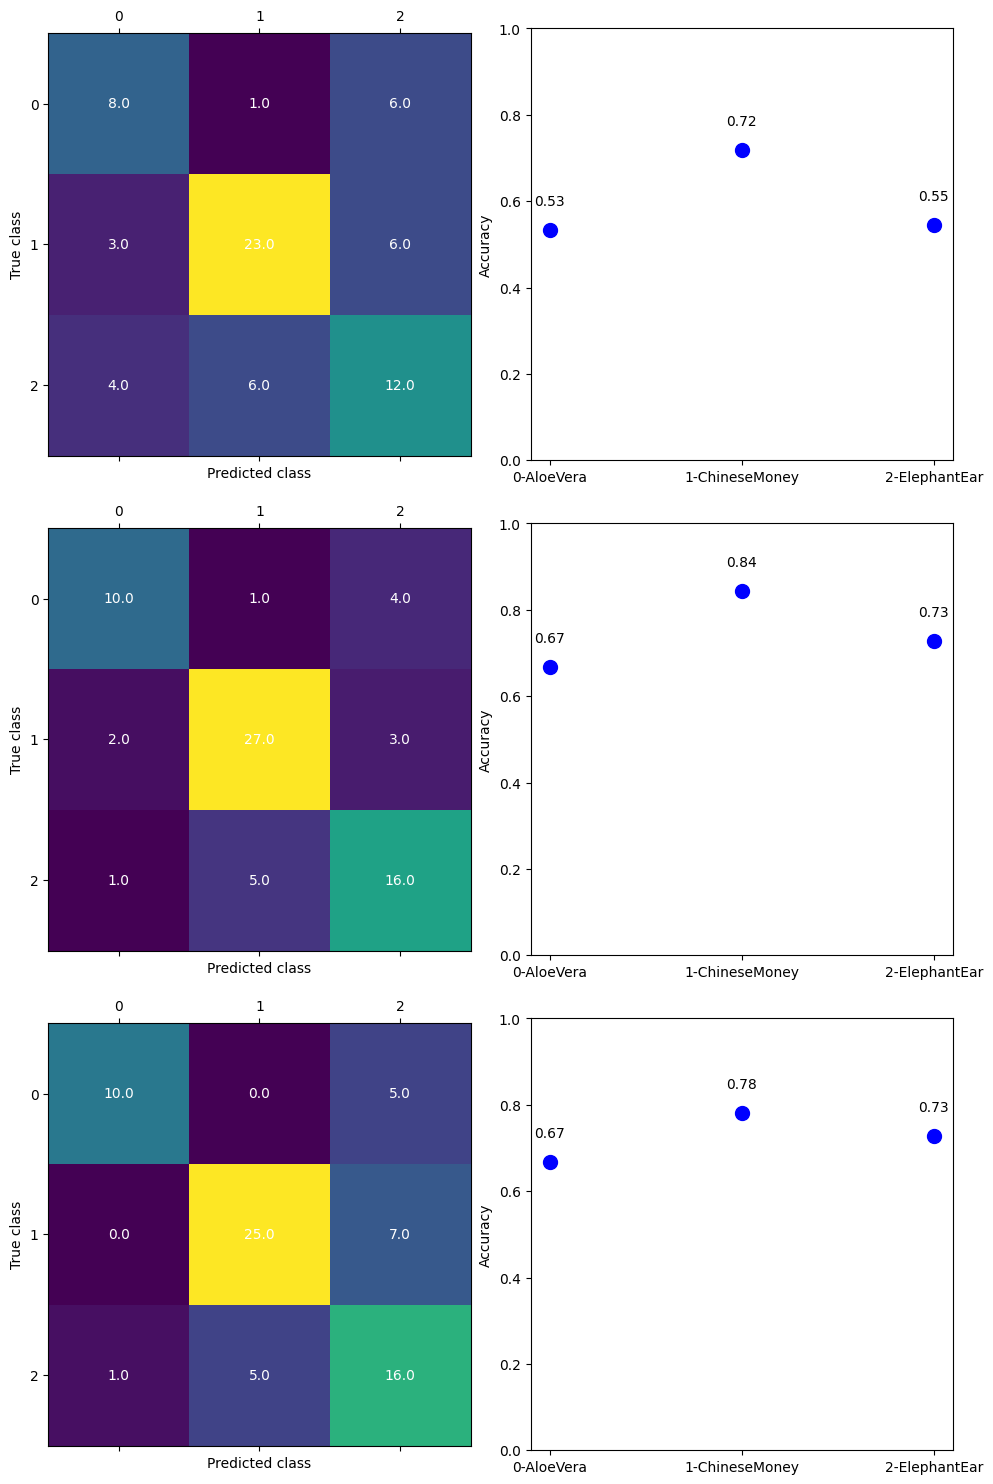

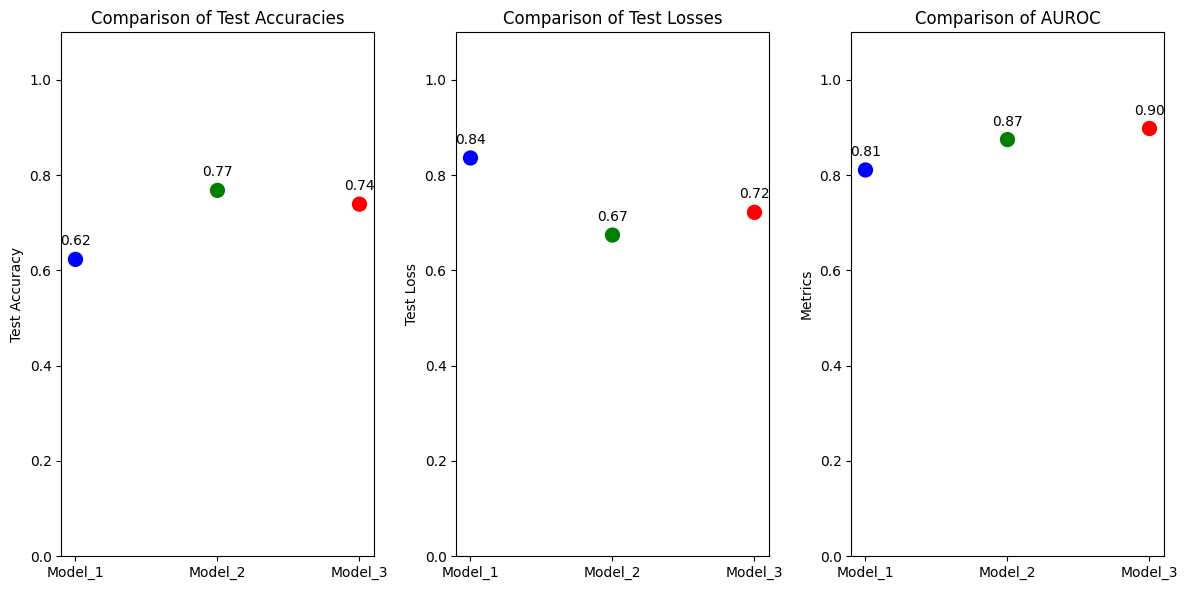

In [ ]:
# -result, metrics, -accuracy, -matrix

confusion_matrices = [array_matrix[0].compute().numpy().astype(float),
                      array_matrix[1].compute().numpy().astype(float),
                      array_matrix[2].compute().numpy().astype(float)]
per_class_accuracies = [array_accuracy[0].compute().numpy().astype(float),
                        array_accuracy[1].compute().numpy().astype(float),
                        array_accuracy[2].compute().numpy().astype(float)]

# Create figure with multiple rows, each containing two subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

for i in range(3):
    # Plot confusion matrix with values
    conf_matrix = confusion_matrices[i]
    cax = axes[i, 0].matshow(conf_matrix)

    for (r, c), val in np.ndenumerate(conf_matrix):
        axes[i, 0].text(c, r, f'{val}', ha='center', va='center', color='white')

    axes[i, 0].set_xlabel('Predicted class')
    axes[i, 0].set_ylabel('True class')

    # Plot per-class accuracy as circles
    per_class_acc = per_class_accuracies[i]
    axes[i, 1].scatter(range(len(per_class_acc)), per_class_acc, s=100, c='blue')
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].set_xticks(range(len(per_class_acc)))
    axes[i, 1].set_xticklabels(['0-AloeVera', '1-ChineseMoney', '2-ElephantEar'])
    axes[i, 1].set_ylabel('Accuracy')
    for j, acc in enumerate(per_class_acc):
        axes[i, 1].text(j, acc + 0.05, f'{acc:.2f}', ha='center', va='bottom', color='black')


fig.tight_layout()

test_accs = [res[0]['test_acc'] for res in array_result if isinstance(res, list) and 'test_acc' in res[0]]
test_losses = [res[0]['test_loss'] for res in array_result if isinstance(res, list) and 'test_loss' in res[0]]
model_names = [f'Model_{i+1}' for i in range(len(test_accs))]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axes[0].scatter(model_names, test_accs, s=100, color=['blue', 'green', 'red'])
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Comparison of Test Accuracies')
axes[0].set_ylim(0, 1.1)
axes[1].scatter(model_names, test_losses, s=100, color=['blue', 'green', 'red'])
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Comparison of Test Losses')
axes[1].set_ylim(0, 1.1)
axes[2].scatter(model_names, array_metrics, s=100, color=['blue', 'green', 'red'])
axes[2].set_ylabel('Metrics')  # Adjust label according to your metrics
axes[2].set_title('Comparison of AUROC')
axes[2].set_ylim(0, 1.1)
for i, txt in enumerate(test_accs):
    axes[0].annotate(f'{txt:.2f}', (model_names[i], test_accs[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(test_losses):
    axes[1].annotate(f'{txt:.2f}', (model_names[i], test_losses[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(array_metrics):
    axes[2].annotate(f'{txt:.2f}', (model_names[i], array_metrics[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()


### Choosing the best model
After we put average per class accuracy for checkpoint condition, we got the best state for each model.

In the following cell we match each model, and choose the best of them.

In [ ]:
best_number = np.argmax([np.mean(i) for i in per_class_accuracies])
best_model = models[best_number]

[np.mean(i) for i in per_class_accuracies]

## ML as a service (gradio)

In [ ]:
checkpoint_path = f"best_model_{best_number+1}.ckpt"
model = ImageClassifier.load_from_checkpoint(checkpoint_path, model=best_model)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((resolution, resolution)),  # Use Resize instead of RandomResizedCrop
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])

if torch.cuda.is_available():
    model.cuda()  # Move the model to the GPU


def classify_image(image):
    image = preprocess(image).unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()
    with torch.no_grad():
        prediction = torch.nn.functional.softmax(model(image)[0], dim=0)
        predicted_class = torch.argmax(prediction, dim=0)

    classes = ["Aloe Vera", "Chinese Plant", "Elephant Ear"]
    return classes[predicted_class.item()]

In [ ]:
test_image = Image.open("images/Aloe_Vera_1.jpg")
classify_image(test_image)

'Elephant Ear'

In [ ]:
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Plant Classifier",
    description="Upload an image of a plant to classify it as Aloe Vera, Chinese Plant, or Elephant Ear.",
    live=True,
)

In [ ]:
interface.launch(inline=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5df8b371d6bb9116c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
